In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import nbconvert
import nbformat
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
gcparks = pd.read_excel('GCPARKS.xlsx')
attendance = pd.read_excel('Attendance.xlsx')
attendance = attendance.set_index('Unnamed: 0')

In [3]:
#Remove Unneeded Columns
gcparks = gcparks.drop('Setid', axis =1)
gcparks = gcparks.drop('Client ID-Claim', axis =1)
gcparks = gcparks.drop('Incident to Claim Date', axis =1)
gcparks = gcparks.drop('Coverage', axis =1)

In [4]:
#Split Datasets into specific parks

grouped = gcparks.groupby('Personnel Area Desc')

dfs = {}

for division, subset in grouped:
    dfs[division] = subset

ecdf = dfs['0569 - EPCOT - FL']
hsdf = dfs['0663 - Disney\'s Hollywood Studios - FL']
mkdf = dfs['2092 - MAGIC KINGDOM 1029 - FL']
akdf = dfs['2227 - ANIMAL KINGDOM 1029 - FL']

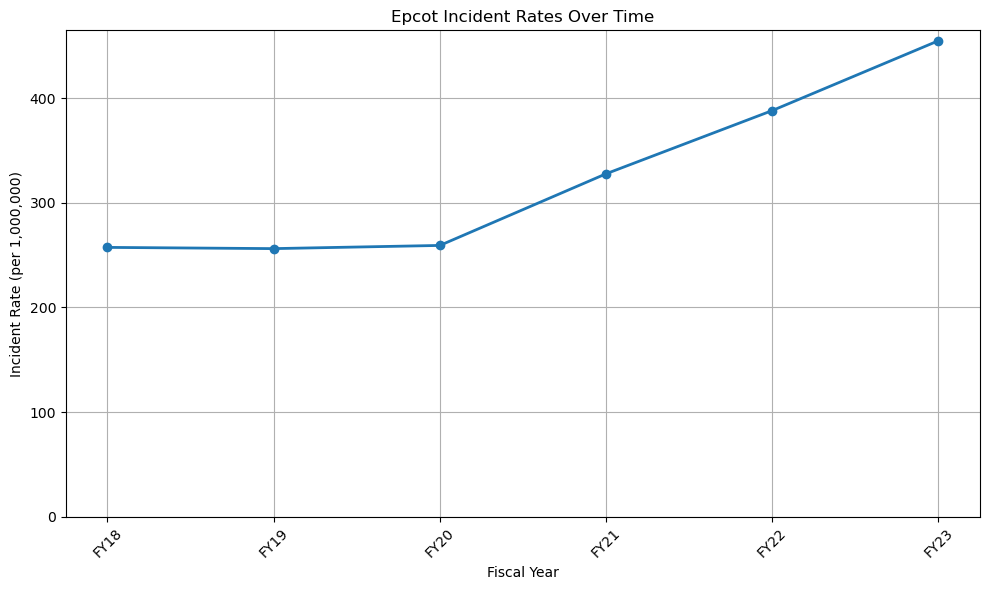

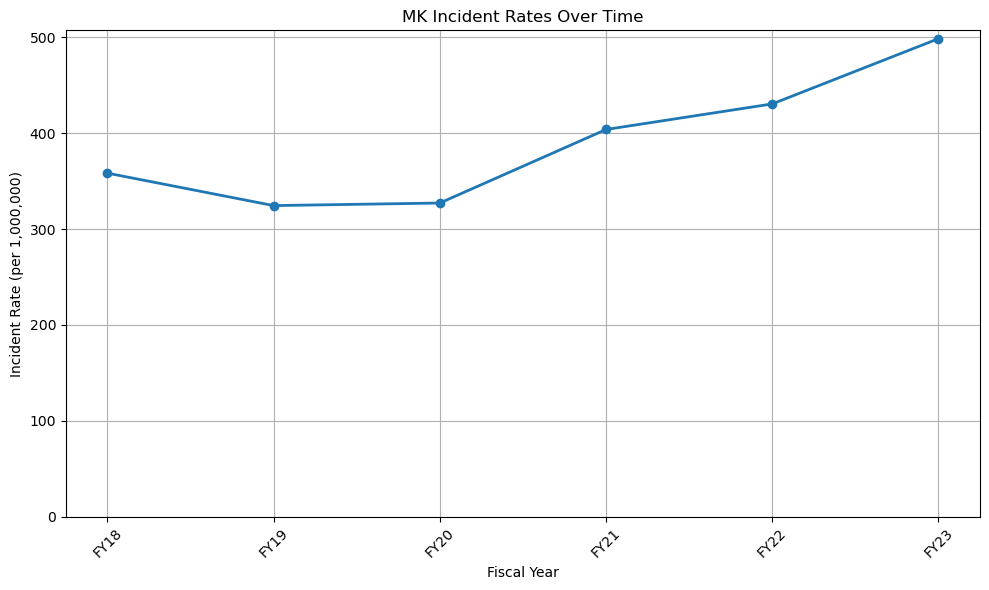

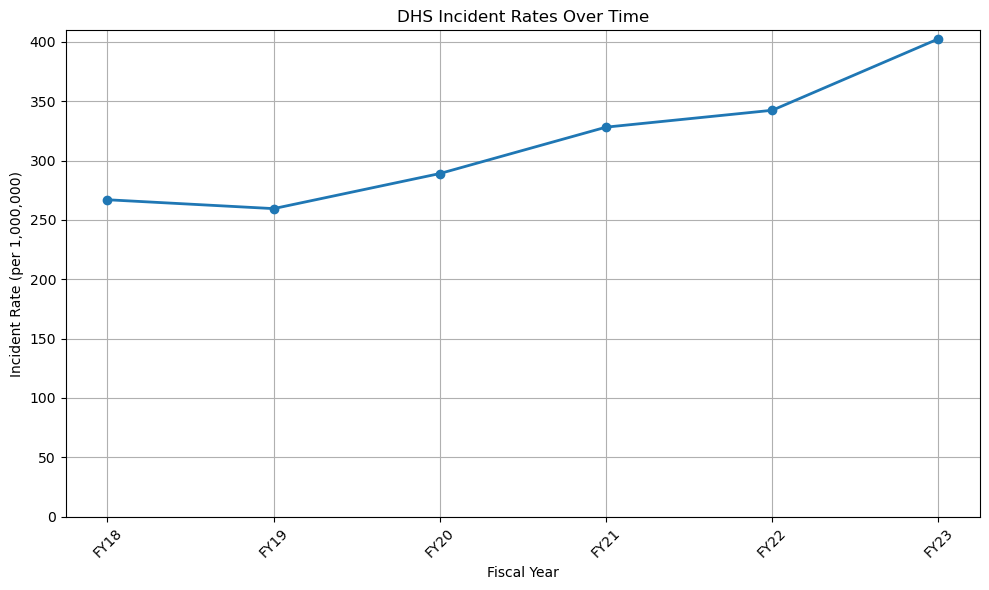

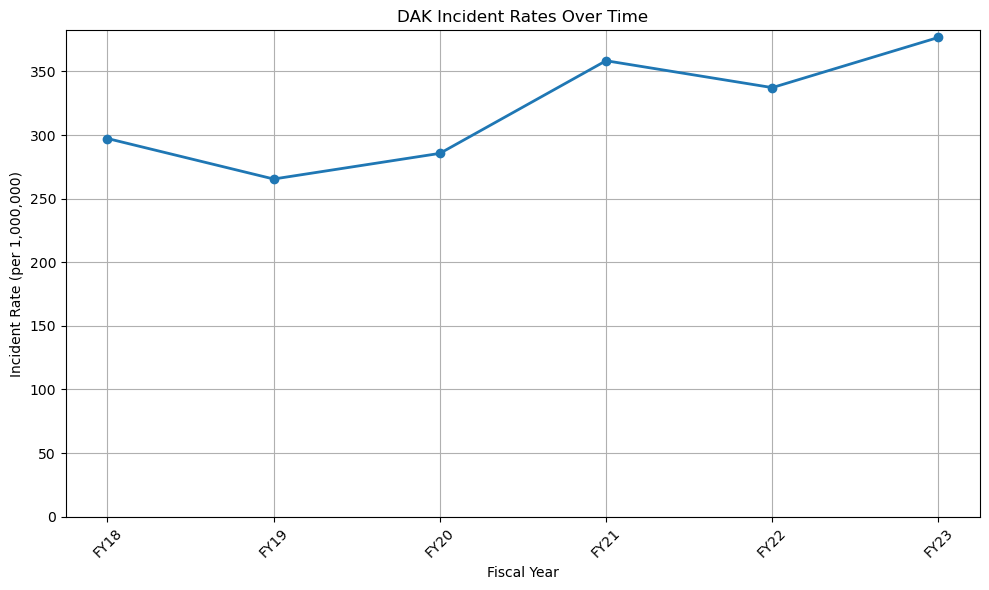

In [5]:
#RATES

def calculate_incident_rates(df, location_name, attendance, fiscal_years):
    total_unique = df['Claim Number'].nunique()
    incident_claim_fy = df.groupby('Fiscal Year')['Claim Number'].nunique()

    claim_count = df[df['Claim Status'] != 'INCIDENT']['Claim Number'].nunique()

    incurred_year = df[df['Claim Status'] != 'INCIDENT'].groupby('Fiscal Year').agg({'Claim Number': 'nunique', 'Disney Claim Total Incurred': 'sum'})
    incurred_total = incurred_year['Disney Claim Total Incurred'].sum()

    values_for_fy = {}
    
    for fiscal_year in fiscal_years:
        value_for_fy = attendance.loc[fiscal_year, location_name]
        values_for_fy[fiscal_year] = value_for_fy
    
    incident_rates = {}
    
    for year in fiscal_years:
        attendance = values_for_fy.get(year, 0)
        incident_claims = incident_claim_fy.get(year, 0)
        
        incident_rate = (incident_claims / attendance * 1000000)
        
        incident_rates[f'{location_name.lower()}incidentrate{year[2:]}'] = incident_rate

    incident_rates_values = [incident_rates.get(f'{location_name.lower()}incidentrate{year[2:]}', 0) for year in fiscal_years]
    
    

    plt.figure(figsize=(10, 6))
    plt.plot(fiscal_years, incident_rates_values, marker='o', linestyle='-', linewidth=2)
    plt.xlabel('Fiscal Year')
    plt.ylabel('Incident Rate (per 1,000,000)')
    plt.title(f'{location_name} Incident Rates Over Time')
    plt.xticks(rotation=45)
    plt.ylim(0)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    incident_rate_data = pd.DataFrame({
        'Location': location_name,
        'Fiscal Year': fiscal_years,
        'Incident Rate (per 1,000,000)': incident_rates_values
    })

    return incident_rate_data


# Define your locations, dataframes, and fiscal years
locations = ['Epcot', 'MK', 'DHS', 'DAK']
dataframes = [ecdf, mkdf, hsdf, akdf]
fiscal_years = ['FY18', 'FY19', 'FY20', 'FY21', 'FY22', 'FY23']

all_incident_rates = pd.DataFrame()  # Create an empty DataFrame to store all incident rates

for location, df in zip(locations, dataframes):
    incident_rate_data = calculate_incident_rates(df, location, attendance, fiscal_years)
    all_incident_rates = pd.concat([all_incident_rates, incident_rate_data], ignore_index=True)

# TO CSV
#all_incident_rates.to_csv('incident_rates_table.csv', index=False)

In [6]:
Rates = all_incident_rates.pivot(index='Fiscal Year', columns='Location', values='Incident Rate (per 1,000,000)')
Rates['4 Park Avg'] = Rates.mean(axis=1)
Rates

Location,DAK,DHS,Epcot,MK,4 Park Avg
Fiscal Year,,,,,
FY18,297.301129,266.970000,257.392600,358.379208,295.010734
FY19,265.454469,259.496541,256.217036,324.552039,276.430021
FY20,285.619607,289.051429,259.260489,327.228636,290.290040
FY21,358.445358,328.127710,327.739926,403.947850,354.565211
FY22,337.308068,342.339030,388.167644,430.624878,374.609905
FY23,376.773461,402.521470,454.914406,498.679613,433.222237


C:\Users\gduln001\AppData\Local\Temp\1\ipykernel_14840\4157035926.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(Rates.index, rotation=45, fontsize=12)


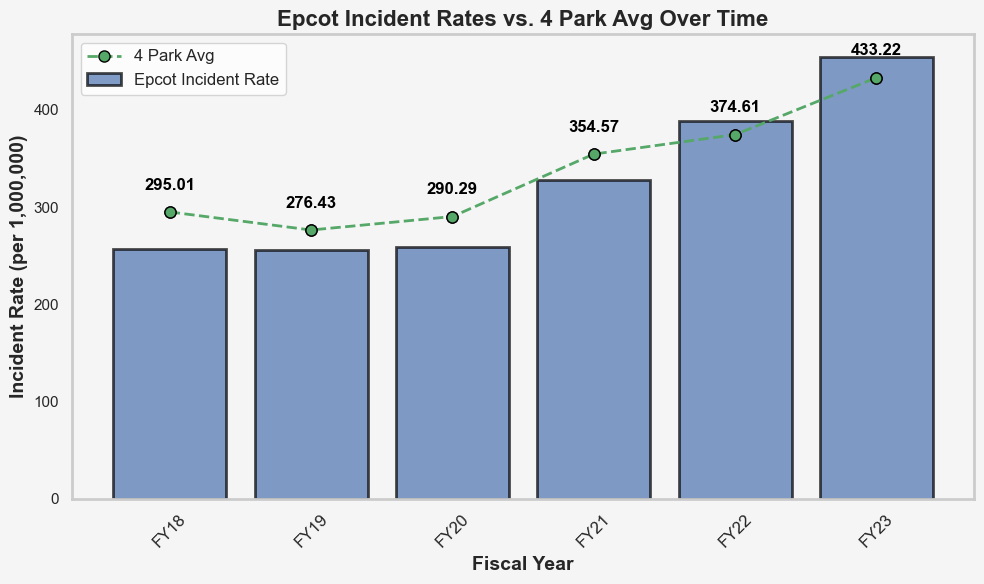

In [7]:
#EPCOT Incident and Claim Rate vs 4 Park Average Visualization

park_to_compare = 'Epcot'

# Select the data for the specific park
specific_park_data = Rates[park_to_compare]

colors = ['#4C72B0', '#55A868']

sns.set(style="whitegrid")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create the bar chart for the specific park with thicker bars
ax.bar(Rates.index, specific_park_data, label=f'{park_to_compare} Incident Rate', color=colors[0], alpha=0.7, edgecolor='black', linewidth=2)

# Plot the 4 Park Avg as a bold dashed line with markers
ax.plot(Rates.index, Rates['4 Park Avg'], color=colors[1], linestyle='--', marker='o', label='4 Park Avg', markersize=8, markeredgecolor='black', linewidth=2)

# Customize chart aesthetics
ax.set_xlabel('Fiscal Year', fontsize=14, fontweight='bold')
ax.set_ylabel('Incident Rate (per 1,000,000)', fontsize=14, fontweight='bold')
ax.set_title(f'{park_to_compare} Incident Rates vs. 4 Park Avg Over Time', fontsize=16, fontweight='bold')
ax.set_xticklabels(Rates.index, rotation=45, fontsize=12)
ax.legend(fontsize=12)

# Add data labels above the 4 Park Avg line in a bold black font with an increased buffer
for x, y in zip(Rates.index, Rates['4 Park Avg']):
    ax.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,14), ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')
    ax.plot(x, y, 'o', markersize=8, markeredgecolor='black', color=colors[1])  # Plot the data points (dots)

# Remove the grid lines
ax.grid(False)

# Fine-tune layout
fig.tight_layout()

# Add a background color to the plot
fig.patch.set_facecolor('#F5F5F5')
ax.set_facecolor('#F5F5F5')

# Show a bold border around the plot
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Show the plot
plt.show()


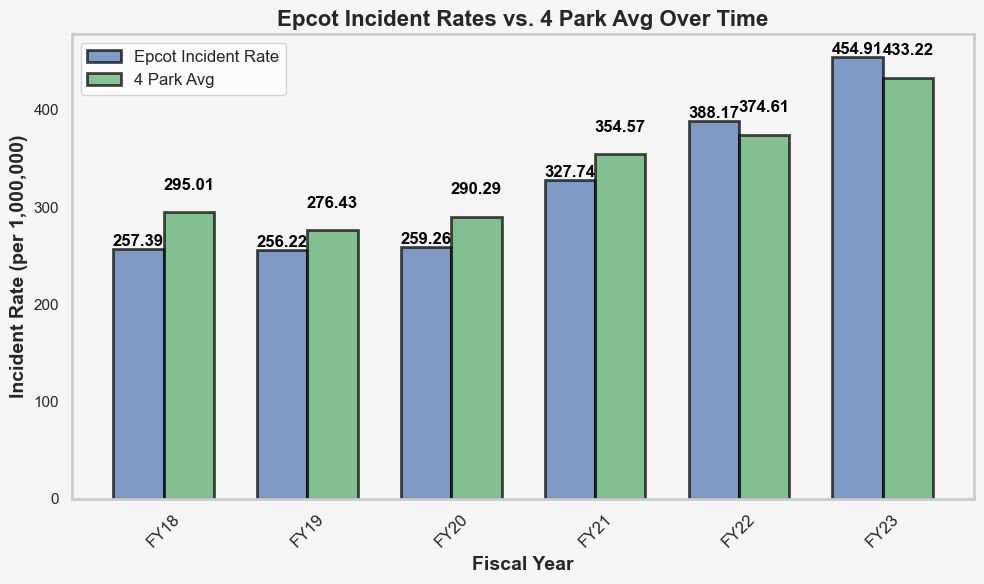

In [8]:

colors = ['#4C72B0', '#55A868']

# Set a custom style using Seaborn
sns.set(style="whitegrid")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Width of each bar
bar_width = 0.35

# Convert the index values to floats for the bar chart
x_values = np.arange(len(Rates.index))

# Create the first set of bars (Specific Park Data)
bar1 = ax.bar(x_values, specific_park_data, width=bar_width, label=f'{park_to_compare} Incident Rate', color=colors[0], alpha=0.7, edgecolor='black', linewidth=2)

# Create the second set of bars (4 Park Avg)
bar2 = ax.bar(x_values + bar_width, Rates['4 Park Avg'], width=bar_width, label='4 Park Avg', color=colors[1], alpha=0.7, edgecolor='black', linewidth=2)

# Customize chart aesthetics
ax.set_xlabel('Fiscal Year', fontsize=14, fontweight='bold')
ax.set_ylabel('Incident Rate (per 1,000,000)', fontsize=14, fontweight='bold')
ax.set_title(f'{park_to_compare} Incident Rates vs. 4 Park Avg Over Time', fontsize=16, fontweight='bold')
ax.set_xticks(x_values + bar_width / 2)
ax.set_xticklabels(Rates.index, rotation=45, fontsize=12)
ax.legend(fontsize=12)

# Add data labels above the bars in a bold black font with an increased buffer
for x, y1, y2 in zip(x_values, specific_park_data, Rates['4 Park Avg']):
    ax.annotate(f'{y1:.2f}', (x, y1), textcoords="offset points", xytext=(0, 0), ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')
    ax.annotate(f'{y2:.2f}', (x + bar_width, y2), textcoords="offset points", xytext=(0, 14), ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

# Remove the grid lines
ax.grid(False)

# Fine-tune layout
fig.tight_layout()

# Add a background color to the plot
fig.patch.set_facecolor('#F5F5F5')
ax.set_facecolor('#F5F5F5')

# Show a bold border around the plot
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Show the plot
plt.show()


In [9]:
dataframes = [ecdf, mkdf, hsdf, akdf]
park_names = ['Epcot', 'MK', 'DHS', 'DAK']
fiscal_years = ['FY18', 'FY19', 'FY20', 'FY21', 'FY22', 'FY23']

Incurred = pd.DataFrame(columns=['Fiscal Year'])

#Calculate the sum
for df, park in zip(dataframes, park_names):
    sum_data = df.groupby('Fiscal Year')['Disney Claim Total Incurred'].sum().reset_index()
    sum_data.rename(columns={'Disney Claim Total Incurred': f'{park} Incurred'}, inplace=True)
    
    Incurred = pd.merge(Incurred, sum_data, on='Fiscal Year', how='outer')

Incurred['Grand Total'] = Incurred.sum(axis=1)

Incurred


,Fiscal Year,Epcot Incurred,MK Incurred,DHS Incurred,DAK Incurred,Grand Total
0,FY18,2263194.34,3588952.51,917147.04,1158388.54,7927682.43
1,FY19,1095566.61,4821704.14,840041.05,689155.31,7446467.11
2,FY20,734352.14,2227075.82,881756.32,555570.68,4398754.96
3,FY21,823037.31,2525943.80,790497.04,732453.45,4871931.60
4,FY22,2891361.09,3402022.37,1045841.61,1549622.81,8888847.88
5,FY23,1109408.42,2816675.67,610792.74,737184.71,5274061.54
6,FY24,400.00,23600.00,4300.00,650.00,28950.00


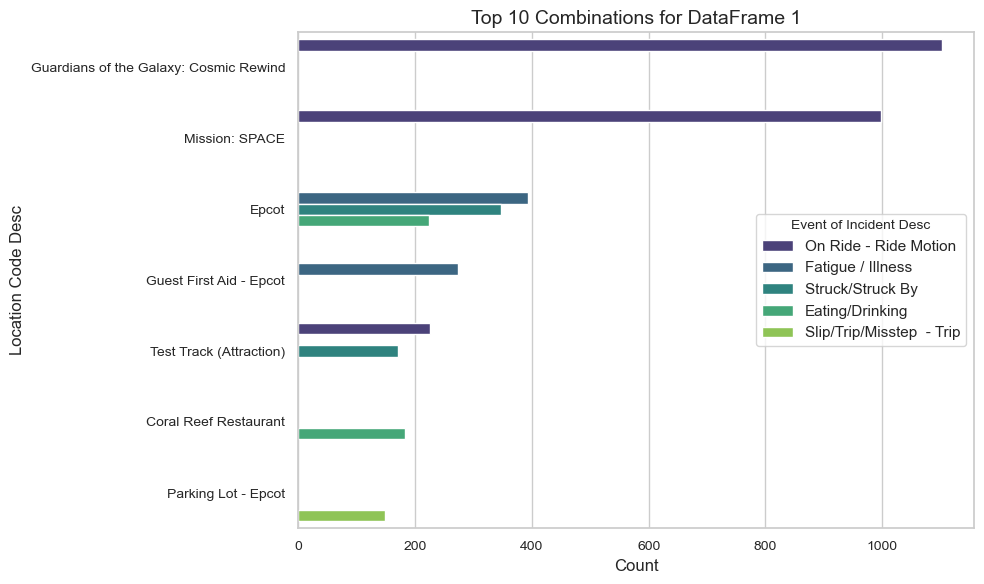

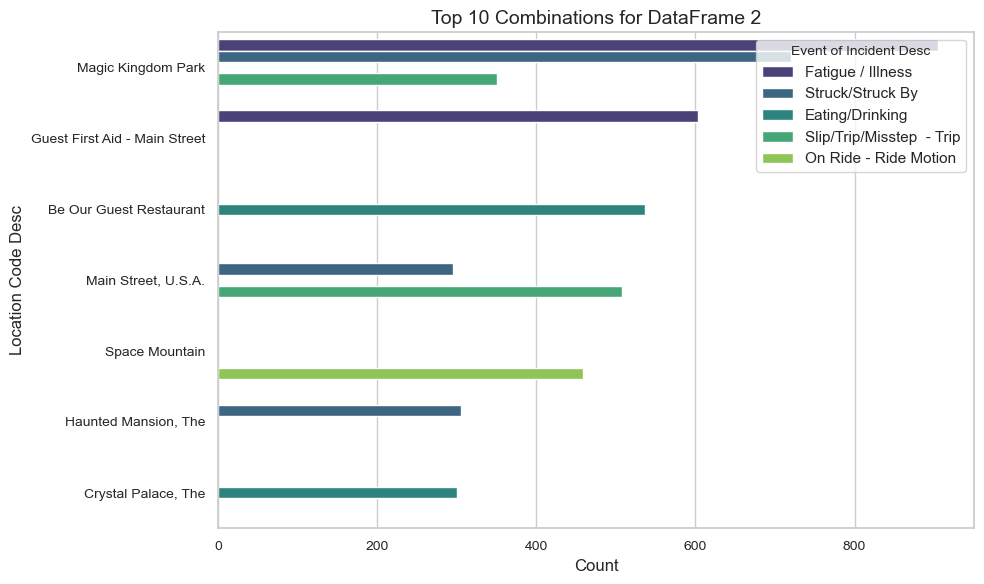

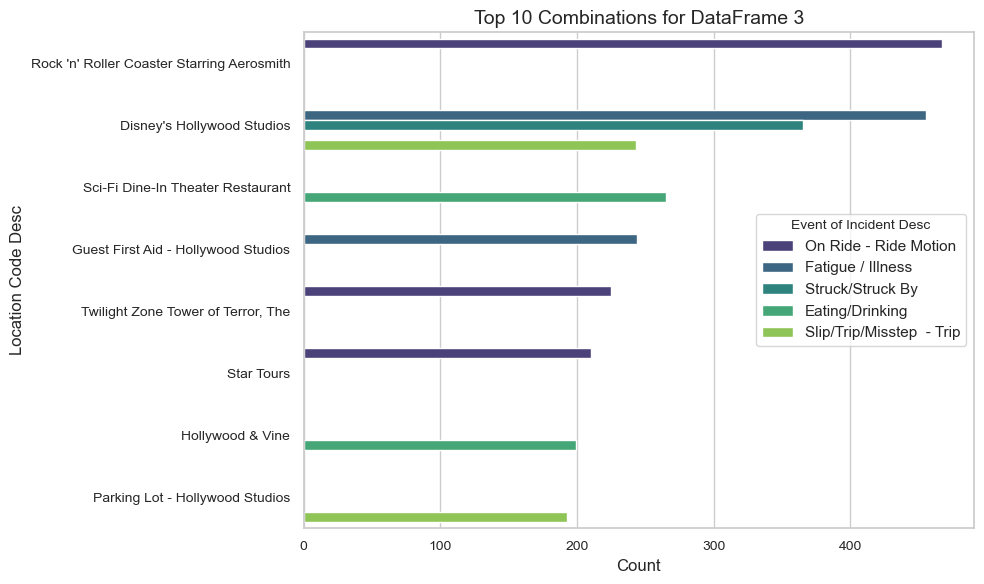

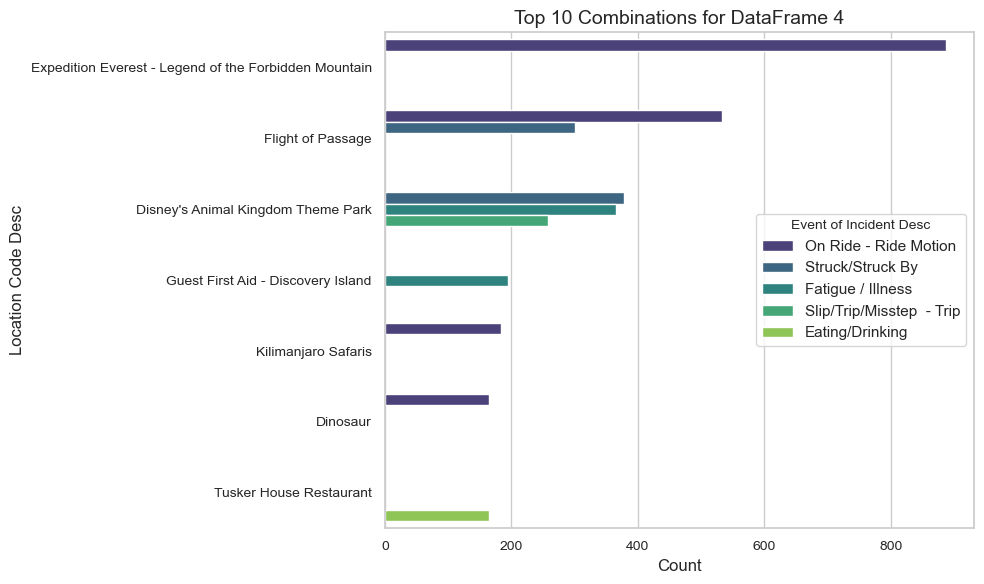

In [10]:
####Exploratory Analysis

dataframes = [ecdf, mkdf, hsdf, akdf]

top_combinations = {}

# Calculating the top 10 combinations for each Location Desc and Event of Incident Desc
for i, dataframe in enumerate(dataframes):
    top_combinations[f"DataFrame {i + 1}"] = dataframe.groupby(['Location Code Desc', 'Event of Incident Desc']).size().reset_index(name='Count').nlargest(10, 'Count')

sns.set(style="whitegrid")

for dataframe_name, top_combos in top_combinations.items():
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Count', y='Location Code Desc', hue='Event of Incident Desc', data=top_combos, palette="viridis")
    plt.title(f"Top 10 Combinations for {dataframe_name}", fontsize=14)
    plt.xlabel("Count", fontsize=12)
    plt.ylabel("Location Code Desc", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(title="Event of Incident Desc", title_fontsize=10)
    plt.tight_layout()
    plt.show()

In [11]:
sorted_dataframes = []  # Initialize an empty list to store the sorted DataFrames

for i, dataframe in enumerate(dataframes):
    table = dataframe.groupby(['Location Code Desc', 'Event of Incident Desc','Source of Incident Desc']).size().reset_index(name='Count')
    sorted_table = table.sort_values(by='Count', ascending=False)
    sorted_dataframe = pd.DataFrame(sorted_table)  # Convert the sorted table to a DataFrame
    sorted_dataframes.append(sorted_dataframe)  # Append the sorted DataFrame to the list

EpcotCombos=sorted_dataframes[0]
EpcotCombos.head(n=10)


,Location Code Desc,Event of Incident Desc,Source of Incident Desc,Count
2172,Guardians of the Galaxy: Cosmic Rewind,On Ride - Ride Motion,Attraction Related - Park Vehicle - Attraction...,1091
3441,Mission: SPACE,On Ride - Ride Motion,Attraction Related - Park Vehicle - Attraction...,988
1185,Epcot,Fatigue / Illness,Person - Self,391
2270,Guest First Aid - Epcot,Fatigue / Illness,Person - Self,271
5225,Test Track (Attraction),On Ride - Ride Motion,Attraction Related - Park Vehicle - Attraction...,214
1139,Epcot,Eating/Drinking,Food/Drink and Related Items - Food Item/Beverage,191
802,Coral Reef Restaurant,Eating/Drinking,Food/Drink and Related Items - Food Item/Beverage,150
145,"American Adventure, The (Attraction)",Eating/Drinking,Food/Drink and Related Items - Food Item/Beverage,128
5232,Test Track (Attraction),On Ride - Sudden Stop,Attraction Related - Park Vehicle - Attraction...,111
1883,"Garden Grill Restaurant, The",Eating/Drinking,Food/Drink and Related Items - Food Item/Beverage,104


In [12]:
MKCombos=sorted_dataframes[1]
MKCombos.head(n=10)

,Location Code Desc,Event of Incident Desc,Source of Incident Desc,Count
4509,Magic Kingdom Park,Fatigue / Illness,Person - Self,900
3135,Guest First Aid - Main Street,Fatigue / Illness,Person - Self,602
654,Be Our Guest Restaurant,Eating/Drinking,Food/Drink and Related Items - Food Item/Beverage,453
6994,Space Mountain,On Ride - Ride Motion,Attraction Related - Park Vehicle - Attraction...,436
2174,"Crystal Palace, The",Eating/Drinking,Food/Drink and Related Items - Food Item/Beverage,262
857,Big Thunder Mountain Railroad,On Ride - Ride Motion,Attraction Related - Park Vehicle - Attraction...,221
1759,Cinderella's Royal Table,Eating/Drinking,Food/Drink and Related Items - Food Item/Beverage,214
1984,Cosmic Ray's Starlight Cafe,Eating/Drinking,Food/Drink and Related Items - Food Item/Beverage,202
6762,Seven Dwarfs Mine Train,On Ride - Ride Motion,Attraction Related - Park Vehicle - Attraction...,193
5248,"Main Street, U.S.A.",Slip/Trip/Misstep - Trip,Walking Surface - Outdoor - Track/Rail,189


In [13]:
HSCombos=sorted_dataframes[2]
HSCombos.head(n=10)

,Location Code Desc,Event of Incident Desc,Source of Incident Desc,Count
3224,Rock 'n' Roller Coaster Starring Aerosmith,On Ride - Ride Motion,Attraction Related - Park Vehicle - Attraction...,460
952,Disney's Hollywood Studios,Fatigue / Illness,Person - Self,452
1631,Guest First Aid - Hollywood Studios,Fatigue / Illness,Person - Self,244
4559,"Twilight Zone Tower of Terror, The",On Ride - Ride Motion,Attraction Related - Park Vehicle - Attraction...,224
3430,Sci-Fi Dine-In Theater Restaurant,Eating/Drinking,Food/Drink and Related Items - Food Item/Beverage,218
3675,Star Tours,On Ride - Ride Motion,Attraction Related - Park Vehicle - Attraction...,202
1717,Hollywood & Vine,Eating/Drinking,Food/Drink and Related Items - Food Item/Beverage,191
3534,Slinky Dog Dash,On Ride - Ride Motion,Attraction Related - Park Vehicle - Attraction...,166
2689,Millennium Falcon: Smugglers Run,On Ride - Ride Motion,Attraction Related - Park Vehicle - Attraction...,145
2369,Mama Melrose's Ristorante Italiano,Eating/Drinking,Food/Drink and Related Items - Food Item/Beverage,137


In [14]:
AKCombos=sorted_dataframes[3]
AKCombos.head(n=10)

,Location Code Desc,Event of Incident Desc,Source of Incident Desc,Count
1478,Expedition Everest - Legend of the Forbidden M...,On Ride - Ride Motion,Attraction Related - Park Vehicle - Attraction...,874
2014,Flight of Passage,On Ride - Ride Motion,Attraction Related - Park Vehicle - Attraction...,498
1185,Disney's Animal Kingdom Theme Park,Fatigue / Illness,Person - Self,366
2295,Guest First Aid - Discovery Island,Fatigue / Illness,Person - Self,195
2811,Kilimanjaro Safaris,On Ride - Ride Motion,Attraction Related - Park Vehicle - Attraction...,177
4271,Tusker House Restaurant,Eating/Drinking,Food/Drink and Related Items - Food Item/Beverage,162
785,Dinosaur,On Ride - Ride Motion,Attraction Related - Park Vehicle - Attraction...,152
1975,Flight of Passage,Fainting/Seizure - Fainting,Person - Self,139
3973,Satu’li Canteen,Eating/Drinking,Food/Drink and Related Items - Food Item/Beverage,118
1240,Disney's Animal Kingdom Theme Park,Slip/Trip/Misstep,Walking Surface,108


In [15]:
#HIGHEST INCURRED WITH NUMBER OF CLAIMS

for i, dataframe in enumerate(dataframes):
    top_combinations[f"DataFrame {i + 1}"] = dataframe.groupby(['Location Code Desc', 'Event of Incident Desc'])[['Disney Claim Total Incurred', 'Claim Number']].agg({'Disney Claim Total Incurred': 'sum', 'Claim Number': 'nunique'}).nlargest(10, 'Disney Claim Total Incurred')

for dataframe_name, top_combos in top_combinations.items():
    print(f"Top 10 Combinations with Total Incurred and Unique Claim Numbers for {dataframe_name}:")
    print(top_combos)
    print("\n")

Top 10 Combinations with Total Incurred and Unique Claim Numbers for DataFrame 1:
                                                                                 Disney Claim Total Incurred  \
Location Code Desc                                 Event of Incident Desc                                      
France                                             Body Motion                                     713607.05   
Guardians of the Galaxy: Cosmic Rewind             Slip/Trip/Misstep  - Misstep                    615350.00   
Parking Lot - Epcot                                Slip/Trip/Misstep  - Trip                       480552.92   
Beauty and the Beast Sing-Along - Impressions d... Body Motion                                     370867.47   
Seas with Nemo & Friends, The                      Slip/Trip/Misstep  - Slip                       252500.00   
Guardians of the Galaxy: Cosmic Rewind             Slip/Trip/Misstep  - Trip                       226000.00   
Mexico                

In [16]:
#TOP 10 MOST COMMON LOCATION/EVENT PER PARK

for i, dataframe in enumerate(dataframes):
    top_combinations[f"DataFrame {i + 1}"] = dataframe.groupby(['Location Code Desc', 'Event of Incident Desc'])[['Claim Number']].nunique().nlargest(10, 'Claim Number')

# Print the top 10 combinations and their sum of Claim Numbers for each DataFrame
for dataframe_name, top_combos in top_combinations.items():
    print(f"Top 10 Location Event Combos based on Sum of Claim Numbers for {dataframe_name}:")
    print(top_combos)
    print("\n")

Top 10 Location Event Combos based on Sum of Claim Numbers for DataFrame 1:
                                                                  Claim Number
Location Code Desc                     Event of Incident Desc                 
Guardians of the Galaxy: Cosmic Rewind On Ride - Ride Motion              1102
Mission: SPACE                         On Ride - Ride Motion               997
Epcot                                  Fatigue / Illness                   393
                                       Struck/Struck By                    347
Guest First Aid - Epcot                Fatigue / Illness                   273
Test Track (Attraction)                On Ride - Ride Motion               225
Epcot                                  Eating/Drinking                     223
Coral Reef Restaurant                  Eating/Drinking                     182
Test Track (Attraction)                Struck/Struck By                    170
Parking Lot - Epcot                    Slip/Trip/Misste